In [ ]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

print('Task 1. (10 점) 데이터 준비하기')
print('Task 1-1. (5 점) 파일을 다운로드 받고 ua.data 파일(학습데이터)과 ua.test 파일(검증데이터)의 내용을 불러와서 Tensor 데이터 생성하기')
print('Task 1-2. (5 점) u.item 파일로부터 영화 id와 title 불러오기')

train = pd.read_csv('/content/ua.base',sep="\t", names=['id', 'movie', 'rating', 'timestamp'])
test = pd.read_csv('/content/ua.test', sep="\t", names=['id', 'movie', 'rating', 'timestamp'])
item = pd.read_csv('/content/u.item', sep="\|", encoding='latin-1', names=['id','title','release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['id'])
ratings = torch.FloatTensor(train['rating'])
items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['id'])
ratings_test = torch.FloatTensor(test['rating'])

data_sample = item.loc[:,['id', 'title']]
data_sample



Task 1. (10 점) 데이터 준비하기
Task 1-1. (5 점) 파일을 다운로드 받고 ua.data 파일(학습데이터)과 ua.test 파일(검증데이터)의 내용을 불러와서 Tensor 데이터 생성하기
Task 1-2. (5 점) u.item 파일로부터 영화 id와 title 불러오기


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if sys.path[0] == '':


,id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


Task 2. (20 점) Latent Factor 모델을 이용하여 학습하기
Task 2-1. (3 점) P, Q, bias_user, bias_item 등 파라미터 초기화하기
Task 2-2. (7 점) regularization과 bias 적용하여 가설, 비용 설정하기
Task 2-3. (5 점) torch.optim을 사용하여 학습하기
Task 2-4. (5 점) 학습데이터와 검증데이터에 대해서 각각 RMSE값을 구하여 출력하기 (training RMSE, test RMSE)
epoch: 0, cost: 101.990021
epoch: 100, cost: 0.063918
epoch: 200, cost: 0.020281
epoch: 300, cost: 0.011708
epoch: 400, cost: 0.008910
epoch: 500, cost: 0.007668
epoch: 600, cost: 0.007001
epoch: 700, cost: 0.006582
epoch: 800, cost: 0.006294
epoch: 900, cost: 0.006085
epoch: 1000, cost: 0.005931


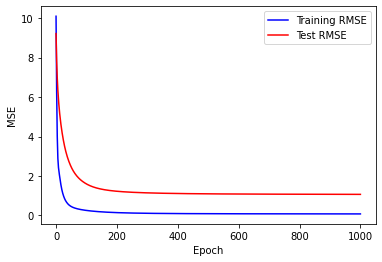

In [ ]:
print('Task 2. (20 점) Latent Factor 모델을 이용하여 학습하기')
print('Task 2-1. (3 점) P, Q, bias_user, bias_item 등 파라미터 초기화하기')
print('Task 2-2. (7 점) regularization과 bias 적용하여 가설, 비용 설정하기')
print('Task 2-3. (5 점) torch.optim을 사용하여 학습하기')
print('Task 2-4. (5 점) 학습데이터와 검증데이터에 대해서 각각 RMSE값을 구하여 출력하기 (training RMSE, test RMSE)')
rank = 100
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)

X = []
Y = []
Y_test = []
lambda1 = 0.00001
lambda2 = 0.00001
lambda3 = 0.0001
lambda4 = 0.0001
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr= 0.1) # 다른숫자바꿔도됨
mean = (ratings.sum() / len(ratings)).item()

for epoch in range(1001):
  hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
  cost = F.mse_loss(hypothesis ,ratings)
  loss = (cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2)) 

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean + bias_item[items_test] + bias_user[users_test]
    cost_test = F.mse_loss(hypo_test, ratings_test)
    Y_test.append(cost_test.item() ** 0.5)
    X.append(epoch)
    Y.append(cost.item() ** 0.5)

  if epoch % 100 == 0:
    print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training RMSE")
plt.plot(X,Y_test, c="red", label="Test RMSE")
plt.legend()
plt.show()

In [ ]:
print('Task 3. (10 점) 13번 User에게 추천하기 (knn search)')

import numpy as np

topMovie = []
topCosine = []

max_rate = []
for i in range(1, len(P)):
  max_rate.append([(P[i] * Q[13]).sum() + mean + bias_item[i] + bias_user[13], i])

max_rate.sort(reverse = True)

print('Task 3-1. (5 점) 13번 user의 예상 별점이 가장 높은 영화 top 20개를 찾아서 id 및 영화이름 출력하기')
count = 1

for i in max_rate[:20]:
  print(count, ') id : ', i[1], '   title :', data_sample.iloc[i[1]-1]['title'])
  topMovie.append(P[i[1]].detach().numpy())
  count += 1

def get_cosine_similarity(x1, x2):
    return (x1 * x2).sum() / ((x1**2).sum()**.5 * (x2**2).sum()**.5)

cosine_list = []
for i in range(1, len(P)):
  A = get_cosine_similarity(P[i],Q[13])
  cosine_list.append([A, i])

cosine_list.sort(reverse=True)

rank = 1
print('---------------------------------------------------------------------------------------------------')
print('Task 3-2. (5 점) Latent Matrix P와 Q를 이용하여 13번 user와 cosine similarity가 가장 유사한 영화 top 20개를 찾아서 id 및 영화이름 출력하기')
for i in cosine_list[:20]:
  print(rank, ') id : ', i[1], '   title :', data_sample.iloc[i[1]-1]['title'])
  topCosine.append(P[i[1]].detach().numpy())
  rank += 1



Task 3. (10 점) 13번 User에게 추천하기 (knn search)
Task 3-1. (5 점) 13번 user의 예상 별점이 가장 높은 영화 top 20개를 찾아서 id 및 영화이름 출력하기
1 ) id :  125    title : Phenomenon (1996)
2 ) id :  528    title : Killing Fields, The (1984)
3 ) id :  246    title : Chasing Amy (1997)
4 ) id :  458    title : Nixon (1995)
5 ) id :  151    title : Willy Wonka and the Chocolate Factory (1971)
6 ) id :  56    title : Pulp Fiction (1994)
7 ) id :  408    title : Close Shave, A (1995)
8 ) id :  1063    title : Little Princess, A (1995)
9 ) id :  699    title : Little Women (1994)
10 ) id :  963    title : Some Folks Call It a Sling Blade (1993)
11 ) id :  566    title : Clear and Present Danger (1994)
12 ) id :  655    title : Stand by Me (1986)
13 ) id :  181    title : Return of the Jedi (1983)
14 ) id :  161    title : Top Gun (1986)
15 ) id :  193    title : Right Stuff, The (1983)
16 ) id :  135    title : 2001: A Space Odyssey (1968)
17 ) id :  177    title : Good, The Bad and The Ugly, The (1966)
18 ) id :  663    t

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math

def kmeans(k, P):
  # 1. 임의로 k개의 점을 중심점으로 선택 (forgy)
  centroids = random.choices(P, k = k)
  prev_assignments = []
  cost = 0

  for epoch in range(10):
    # 2. 각 점이 할당될 중심점을 계산
    assignments = []
    for p in P:
      min_c_idx = -1
      min_c_dist = 100000
      for i, c in enumerate(centroids):
        cosine_distance = 1 - get_cosine_similarity(p, c)
        if(min_c_dist > cosine_distance):
          min_c_dist = cosine_distance
          min_c_idx = i
      assignments.append(min_c_idx)
      
    # 3. 새로운 centroid 계산
    clusters = [[] for _ in range(k)]
    
    for a, b in zip(assignments, P):
      clusters[a].append(b)
    
    centroids = [np.mean(c, axis = 0 ) for c in clusters] 
    
    # 4. 클러스터에 변화가 없을 경우 종료
    if(prev_assignments == assignments):
      break
    prev_assignments = assignments
  
  return assignments, centroids


Task 4-3. (5 점) 가장 적절해보이는 k 선택하기


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


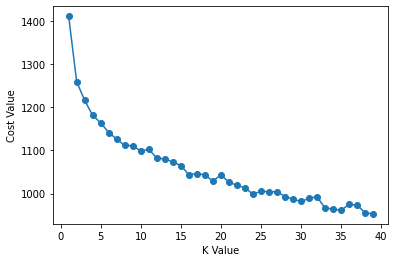

In [ ]:
print('Task 4-3. (5 점) 가장 적절해보이는 k 선택하기')

cost_list = []

for i in range(1, 40):
  assignments, centroids = kmeans(i, P.detach().numpy())
  cost = 0

  for j in range(len(P)):
    A = (1 - (get_cosine_similarity(P[j].detach().numpy(), centroids[assignments[j]])))
    # 1 - cosinesimilarity를진행하여 거리대신 코스트를 뽑아줌 
    cost += A
  cost_list.append(cost)

X = []

for i in range(1,len(cost_list) + 1):
  X.append(i)

plt.plot(X, cost_list, marker='o')
plt.xlabel('K Value')
plt.ylabel('Cost Value')
plt.show()

In [1]:
print("Arm Point가 가장 뚜렷하게 보이는 K = 7 일 때 가장 적절하다.")

Arm Point가 가장 뚜렷하게 보이는 K = 7 일 때 가장 적절하다.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Task 5. (30 점) 차원 축소 및 시각화 (PCA)
Task 5-1. (5 점) P 행렬와 Q 행렬을 합쳐 Z행렬 만들기
Task 5-2. (10 점)Z 행렬에서 PCA 수행하여 2차원 데이터로 줄인 Zp 만들기
Task 5-3. matplotlib을 활용하여 Zp의 scatter plot 그리기
Task 5-3-1. (5 점) P행렬과 Q행렬의 점들을 서로 다른 색으로 그리기
Task 5-3-2. (5 점) Task 3의 결과 점들을 다른 색으로 그려 강조하기
Task 5-3-3. (5 점) Task 4에서 구한 cluster들을 각기 다른 색으로 그리기


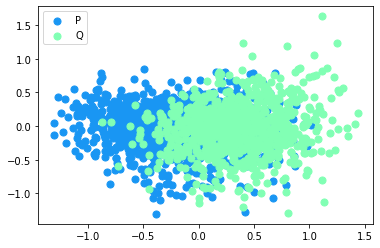

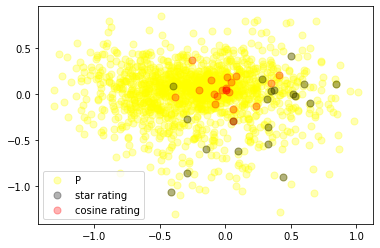

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

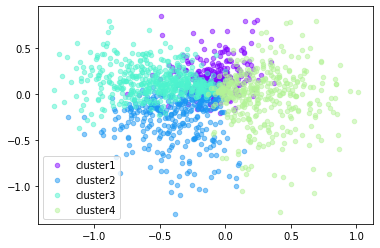

In [ ]:
print("Task 5. (30 점) 차원 축소 및 시각화 (PCA)")

import torch
import requests
import matplotlib.pyplot as plt


print("Task 5-1. (5 점) P 행렬와 Q 행렬을 합쳐 Z행렬 만들기")

Z = torch.cat((P, Q), dim = 0)

print("Task 5-2. (10 점)Z 행렬에서 PCA 수행하여 2차원 데이터로 줄인 Zp 만들기")
print("Task 5-3. matplotlib을 활용하여 Zp의 scatter plot 그리기")
print("Task 5-3-1. (5 점) P행렬과 Q행렬의 점들을 서로 다른 색으로 그리기")
print("Task 5-3-2. (5 점) Task 3의 결과 점들을 다른 색으로 그려 강조하기")
print("Task 5-3-3. (5 점) Task 4에서 구한 cluster들을 각기 다른 색으로 그리기")

from sklearn import decomposition


X = Z.detach().numpy()
pca = decomposition.PCA(2)
pca.fit(X)
T = pca.transform(X[:len(P)-1])
R = pca.transform(X[len(P):])

# P행렬과 Q행렬의 점들을 서로 다른 색으로 그리기
plt.scatter(T[:,0], T[:,1], s= 50, c=plt.cm.rainbow(0.2), label = 'P')
plt.scatter(R[:,0], R[:,1], s= 50, c=plt.cm.rainbow(0.5), label = 'Q')

plt.legend(fontsize= 10)
plt.show()

# Task 3의 결과 점들을 다른 색으로 그려 강조하기
# 별점 Top20 영화

cosinestar = [P.detach().numpy(), topMovie, topCosine]
cosinestarlabel = ['P', 'star rating', 'cosine rating']
cosineColor = ['Yellow', 'Black', 'Red']
for i, c in enumerate(cosinestar):
  Z = pca.transform(c)
  plt.scatter(Z[:,0], Z[:,1], s= 50, c= cosineColor[i], label = cosinestarlabel[i], alpha=0.3)

plt.legend(fontsize= 10)
plt.show()

# Task 4에서 구한 cluster들을 각기 다른 색으로 그리기
k = 4

assignments, centroids = kmeans(k, P.detach().numpy())

clusters = [[] for _ in range(k)]
    
for a, b in zip(assignments, P):
    clusters[a].append(b.detach().numpy())

clusterlist = ['cluster1', 'cluster2','cluster3','cluster4']
for i, c in enumerate(clusters):
  Z = pca.transform(c)
  plt.scatter(Z[:,0], Z[:,1], s= 20, c=plt.cm.rainbow(i*0.2), label = clusterlist[i], alpha=0.5)

plt.legend(fontsize= 10)
plt.show()
